# 신생아 이름 분석

- 시대별로 특정 이름이 차지하는 비율을 구해 얼마나 흔한 이름인지 알아보기
- 이름의 상대 순위 알아보기
- 각 연도별 가장 인기 있는 이름, 가장 빈도가 높거나 낮은 이름 알아보기
- 모음, 자음, 길이, 전반적인 다양성, 철자 변화, 첫글자와 마지막 글자 등, 이름 유행 분석하기
- 성서에 등장하는 이름, 유명인, 인구통계학적 변화 등 외부 자료를 통한 유행 분석하기

In [6]:
!head -n 10 .\ch02\names\yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


In [8]:
import pandas as pd
names1880 = pd.read_csv('ch02/names/yob1880.txt', names=['name', 'sex', 'births'])

이 데이터는 각 연도별로 최소 5명 이상 중복되는 이름만 포함하고 있음.   
따라서, 성별 출생 수를 모두 합한 값을 해당 연도의 전체 출생수라고 가정한다. (말그대로 가정)

In [25]:
names1880[-10:]

,name,sex,births
1990,Unknown,M,5
1991,Vann,M,5
1992,Wes,M,5
1993,Winston,M,5
1994,Wood,M,5
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5
1999,Zachariah,M,5


In [26]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

In [28]:
years = range(1880, 2011)
pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = 'ch02/names/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)

names = pd.concat(pieces, ignore_index=True)

In [39]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690784 entries, 0 to 1690783
Data columns (total 4 columns):
name      1690784 non-null object
sex       1690784 non-null object
births    1690784 non-null int64
year      1690784 non-null int64
dtypes: int64(2), object(2)
memory usage: 51.6+ MB


## 연도 및 성별에 따른 데이터 분류

groupby 혹은 pivot_table 을 사용하여 데이터를 재설정할 수 있음

## pivot_table 을 이용한 구현


In [40]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

In [41]:
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


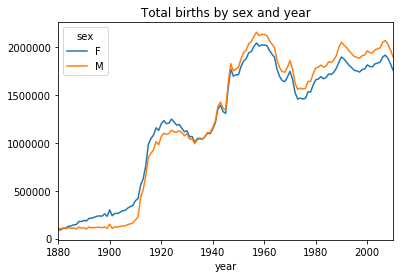

In [43]:
total_births.plot(title='Total births by sex and year')

## GroupBy 를 이용한 구현

pivot_table 을 groupby 를 통해서 동일하게 구현이 가능하다.  
   
주의할 점은 리턴 타입이 GroupBy Object 이므로 unstack() 메서드를 통해 이를 DataFrame 으로 변환한다.  
   
이 구현은 plotting 시 pivot_table 과 동일한 효과가 있다.

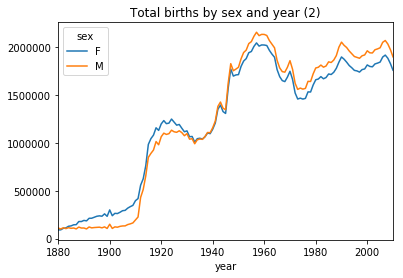

In [58]:
names.groupby(['year', 'sex'], axis=0, group_keys='year').births.sum().unstack().plot(title='Total births by sex and year (2)')

## 각 이름이 차지하는 비율 구하기

각 이름별로 plotting 을 한다.  
groupby 에 사용될 사용자 정의 연산을 정의해야 하고  
이를 적용하기 위해서는 groupby 오브젝트의 apply 메서드를 활용한다.  


### 그룹 연산 팁(Tip)

아래와 같이 apply 함수를 통해서 수행하는 그룹 연산에 새너티 테스트(Sanity Check)를 하는게 좋다고 한다. (책에서)    
이 때, np.allclose 를 활용한다고 한다.   
   
이 경우는 전체 출생 수에 대한 각 이름별 비율이므로 전체 합이 1이 되어야 한다.

In [67]:
import numpy as np

In [60]:
def add_prop(group):
    """GroupBy.apply() 메서드에 사용될 함수로써 prop 칼럼에 할당될 "전체 출생수에 대해 각 이름이 차지하는 비율"
    @param group: 
    """
    # integer division floors
    births = group.births.astype(float) # float 형으로 births 칼럼을 추출한다. 
    group['prop'] = births / births.sum() # 비율을 구한다.
    return group

    

In [63]:
names = names.groupby(['year','sex']).apply(add_prop)

In [70]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

## 이름 유행 분석
   
   
이름 유행 분석을 위해서 출생률을 기준으로 TOP 1000 개 항목을 도출해야 하며,   
이를 도출하는 방법은 아래의 방법 외에도 함수를 정의하지 않는 방법이 있다.


```python
pieces = [] 
for year, group in names.groupby(['year','sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
top1000 = pd.concat(pieces, ignore_index=True)
```

In [72]:
def get_top1000(group):
    """ births 칼럼에 대해서 내림차순(ascending=False) 정렬을 한 뒤에 상위 1000 개 항목을 추출한다.
    """
    return group.sort_values(by='births', ascending=False)[:1000]

In [73]:
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

In [75]:
top1000.head()

name sex  births  year      prop
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077643
         1       Anna   F    2604  1880  0.028618
         2       Emma   F    2003  1880  0.022013
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188

새로운 인덱스를 할당한다. 

In [77]:
top1000.index = np.arange(len(top1000))
top1000.head()

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


상위 1000 개의 데이터를 남자아이와 여자아이로 분리

In [78]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

In [80]:
boys.tail()

,name,sex,births,year,prop
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102
261876,Maxton,M,193,2010,0.000102


## 데이터 체크
   
   
피벗 테이블을 통해 연도, 이름에 대한 출생수를 plotting 을 통해 확인한다. 이 때, 특정 이름 샘플에 대해서 우선 파악하고 전반적인 결론을 내리기 위해 추가적인 분석을 진행한다.

In [81]:
total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)

In [83]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 1880 to 2010
Columns: 6868 entries, Aaden to Zuri
dtypes: float64(6868)
memory usage: 6.9 MB


아래의 ["Number of births per year"] 그래프를 통해서 John, Harry 등의 흔한 이름의 사용 빈도가 점점 낮아지는 것을 볼 수 있음   
   
하지만, 이는 정확한 분석이 아니므로 데이터 수집 기간에 걸쳐 인기 있는 이름 상위 1000 개가 전체 출생 수에 차지하는 비율을 그래프로 표시해본다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F47A14278>,
      dtype=object)

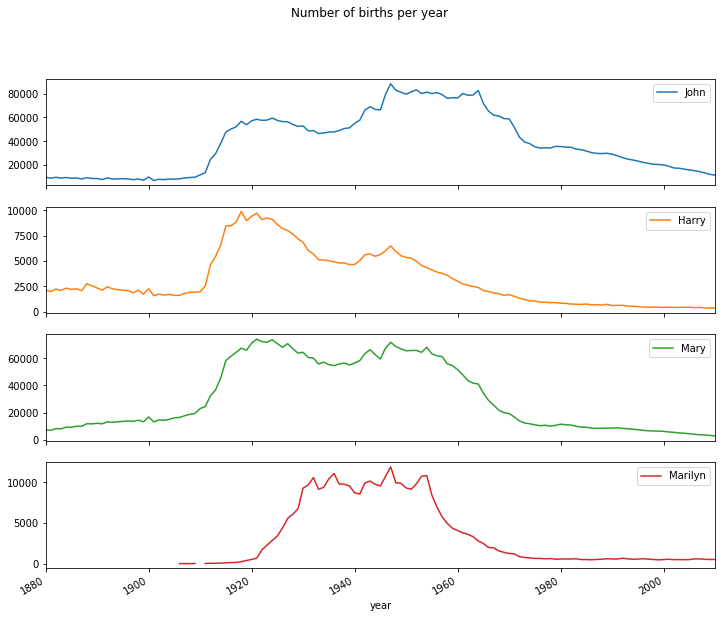

In [86]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12,10), grid=False, title="Number of births per year")

## 다양한 이름을 사용하는 경향 파악
   
우리는 이미 prop 칼럼을 통해서 년도별 출생률을 각 이름별로 구하였다.   
   
그리고 np.allclose 를 이용해서 prop 칼럼의 합이 1에 수렴하는지를 체크한 결과 "True" 라는 결론을 얻어내었다. (Sanity Check)

따라서, 집계한 TOP 1000 개의 이름의 Prop 합을 구하면 전체 출생률에 대해서 차지하는 비율을 확인할 수 있다. 이를 통해서 인기 있는 이름들이 연도별로 차지하는 비율이 증가혹은 감소하는 지를 통해서 이름이 다양화되는 추세를 짐작해 볼 수 있다.

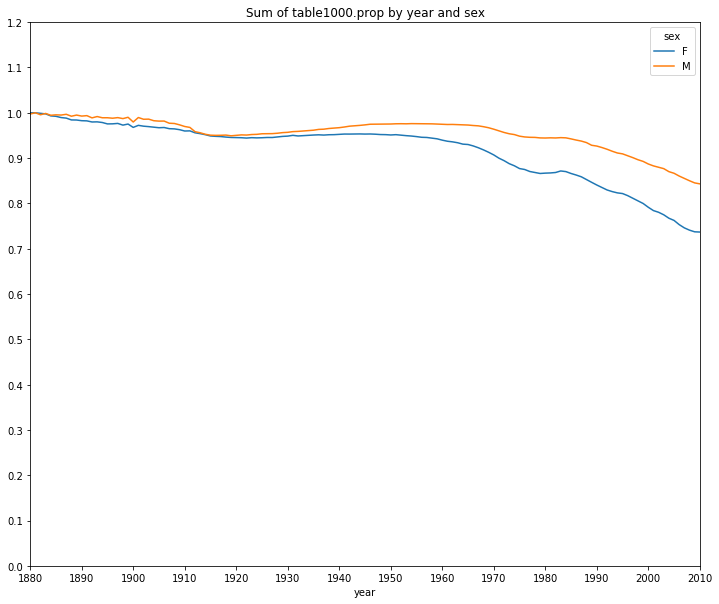

In [89]:
table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc='sum')
table.plot(title='Sum of table1000.prop by year and sex', yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10), figsize=(12,10))

**"Sum of table1000.prop by year and sex"의 해설** :  위 데이터를 통해서 추측컨데, 인기있는 이름의 사용비율이 점차 낮아지고 있음을 알 수 있다. 이러한 사례는 특히 여성(Female)의 경우 두드러진다.

In [92]:
df = boys[boys.year == 2010]
df.head()

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887


### 인기 있는 이름 순으로 정렬 및 전체 출생수의 50%를 차지하기 까지 등장하는 이름의 개수
   
   
prop을 내림차순으로 정렬하고 전체의 50%가 되기까지 얼마나 많은 이름으 등장하는지 알아본다.

```python
df.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum.values.searchsorted(0.5)
```



In [101]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum() # Series 객체이다.
prop_cumsum[-10:]

261867    0.842236
261868    0.842338
261869    0.842441
261870    0.842544
261871    0.842646
261872    0.842748
261873    0.842850
261874    0.842953
261875    0.843055
261876    0.843156
Name: prop, dtype: float64

2010년도 출생률 누적 합계가 0.5 가되는 지점을 아래와 같은 방식으로 찾는다. 그리고 그 결과에서 117 (116 + 1) 번째 (배열의 색인은 0부터 시작하므로)까지 0.5를 보괄하는 지점이다.

In [102]:
prop_cumsum.values.searchsorted(0.5)

116

In [108]:
prop_cumsum[115:119]# 116, 117, 118, 119 포함

260992    0.498861
260993    0.500652
260994    0.502442
260995    0.504222
Name: prop, dtype: float64

In [112]:
prop_cumsum.iloc[115] # 116 부터 0.5 를 넘는 것으로 확인되며 이는 함수를 사용한 결과와 일치

0.4988606086656953

In [114]:
df = boys[boys.year == 1900]
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()
in1900.searchsorted(0.5) + 1

25

### 1900 년도 vs 2010 년도
   
   
1900 년도와 2010 년도의 누적 출생률 합계가 50% 내에 포함되는 "이름의 개수"를 파악한 결과 각각 25, 117 개 이다.   
이 값을 통해 시간이 지날 수록 이름이 다양해 지고 있음을 알 수 있다. 그렇다면 "여성의 이름이 남성의 이름보다 다양한 지를 검증해보자."

In [115]:
# 위의 절차를 함수를 통해서 구현
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q) + 1

In [116]:
diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)

In [125]:
diversity = diversity.unstack('sex') # DataFrame 화 한다.

아래의 그래프를 통해 상위 50%에 포함되는 인기있는 이름의 갯수가 시간이 지남에 따라 증가하는 것을 확인할 수 있으며, 여자아이의 경우 더 다양해지는 경향을 보인다.

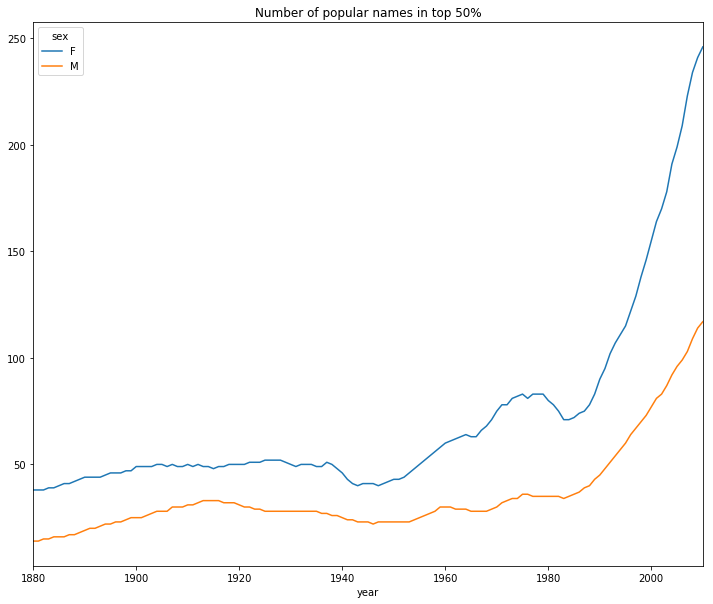

In [129]:
diversity.plot(title='Number of popular names in top 50%', figsize=(12,10))